In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
# sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
from ADlasso2 import AD2_w_utils_lossdiff as ad

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Ignore section lambda decision
(Feature 數量為零之後的lambda就不要了)

In [3]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch\Level2_log_inv\tuning_result")
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/tuning_result')

In [8]:
def ignore_section_lambda_decision(tuning_dict, celltype, start_idx=0, version='new', output_dir=''):
    if version == 'new':
        # convert tuning_dict to old format
        tuning_old_format = {}
        for outer_key in tuning_dict.keys():
            for inner_key, value in tuning_dict[outer_key].items():
                if inner_key not in tuning_old_format.keys():
                    tuning_old_format[inner_key] = []
                tuning_old_format[inner_key].append(value)
    else:
        tuning_old_format = tuning_dict

    for key in tuning_old_format.keys():
        tuning_old_format[key] = np.array(tuning_old_format[key])
    
    # start index should be the index of lambda at which the BCE curve does not look strange
    if start_idx > 0:
        print('Start index:', start_idx)
    # Find the index of feature_number start to become 0
    cut_idx = len(tuning_old_format['Feature_number'])
    for i in range(len(tuning_old_format['Feature_number'])):
        if tuning_old_format['Feature_number'][i] == 0:
            cut_idx = i
            print('Cut index:', cut_idx)
            break

    trimmed_tuning = {}
    for k in tuning_old_format.keys():
        trimmed_tuning[k] = tuning_old_format[k][start_idx:cut_idx]

    def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, start_idx=0, savepath=''):
        fig, ax1 = plt.subplots(figsize = (8, 5))
        ax2 = ax1.twinx()

        line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
        line2, = ax2.plot(np.exp(tuning['log_lambda_range']), tuning['Feature_number'], marker='o', color='orange')
        ax1.set(xscale="log")

        # vertical line for optimal lambda
        plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
        
        # vertical line for start lambda (blue)
        if start_idx > 0:
            # only plot the start line when the start_idx is not the first index
            print('Start:', np.exp(tuning['log_lambda_range'][start_idx]))
            # vertical line for start lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][start_idx]), color = 'blue', linestyle=':')
        # vertical line for cut lambda (red)
        if cut_idx < len(tuning['log_lambda_range']):
            # only plot the cut line when the cut_idx is not the last index
            print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
            # vertical line for cut lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
        
        # horizontal line for feature number = 0 (this does not make sense with y log scale)
        # plt.axhline(y=0, color = 'black', linestyle='--')

        ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
        ax1.set_ylabel("Loss"); ax2.set_ylabel("Feature number")
        ax2.set_yscale("log")  # set log scale for feature number
        ax2.set_ylim(bottom=0.5, top=None)  # set ylim for feature number  # EDITTED
        ax1.set_title(f'{celltype} lambda decision')
        plt.legend(handles=[line1, line2], labels=['BCE loss', 'Feature_number'], loc='upper left')

        if savepath:
            plt.savefig(savepath, dpi=300)

    # Lambda decision from trimmed tuning result
    # TODO: reset k value of lambda decision
    opt_lmbd, fig = ad.lambda_decision(trimmed_tuning, k=3, savepath=output_dir + f'{celltype}_lambda_decision_trimmed.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning_old_format['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning_old_format['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning_old_format, celltype, opt_lmbd, cut_idx, start_idx=start_idx, savepath=output_dir + f'{celltype}_lambda_decision_all.png')

    return opt_lmbd, feature_no_celltype

In [5]:
opt_lmbd_dict = {}
feature_no_dict = {}

In [7]:
# queue = ['ASDC', 'CD4_Proliferating', 'CD8_Proliferating', 'Eryth', 'ILC']  # RCT
queue = ['dnT', 'Treg', 'CD8_Proliferating', 'ILC', 'CD8_TCM']

In [9]:
# for celltype in queue:
#     tuning_file = f'{celltype}_tuning.json'
#     if not os.path.exists(tuning_file):
#         print(f"File {tuning_file} does not exist. Skipping to the next cluster.")
#         continue

#     print('====================')
#     print(f'Cell type: {celltype}')
#     with open(tuning_file) as f:
#         tuning = json.load(f)

#     output_dir = r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch\Level2_log_inv\lambda_decision_2" + '\\'
#     opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, version='old', output_dir=output_dir)
#     opt_lmbd_dict[celltype] = opt_lmbd
#     feature_no_dict[celltype] = feature_no_celltype

### Function for running lambda decision for a single cell types
def run_lmbd_decision(celltype, start_idx=0, output_dir=''):
    tuning_file = f'{celltype}_tuning.json'
    if not os.path.exists(tuning_file):
        print(f"File {tuning_file} does not exist. Skipping to the next cluster.")
        return

    print('====================')
    print(f'Cell type: {celltype}')
    with open(tuning_file) as f:
        tuning = json.load(f)

    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, start_idx=start_idx, version='old', output_dir=output_dir)
    opt_lmbd_dict[celltype] = opt_lmbd
    feature_no_dict[celltype] = feature_no_celltype

dnT 0
Cell type: dnT
Cut index: 22
Optimal lambda: 0.00046415888336127795
Feature no: 63
Cut: 0.04641588833612786
Treg 0
Cell type: Treg
Cut index: 24
Optimal lambda: 0.00031622776601683783
Feature no: 268
Cut: 0.10000000000000002
CD8_Proliferating 3
Cell type: CD8_Proliferating
Start index: 3
Cut index: 20
Optimal lambda: 0.00046415888336127795
Feature no: 34
Start: 3.16227766016838e-05
Cut: 0.02154434690031885
ILC 1
Cell type: ILC
Start index: 1
Cut index: 21
Optimal lambda: 0.0002154434690031884
Feature no: 56
Start: 1.4677992676220687e-05
Cut: 0.0316227766016838
CD8_TCM 0
Cell type: CD8_TCM
Cut index: 24
Optimal lambda: 0.00046415888336127795
Feature no: 328
Cut: 0.10000000000000002


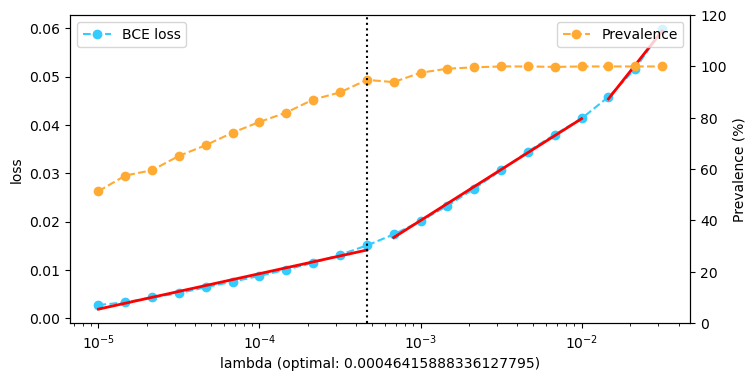

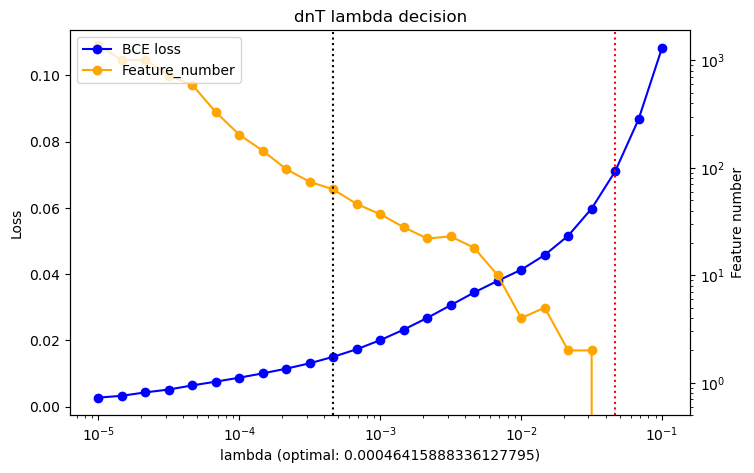

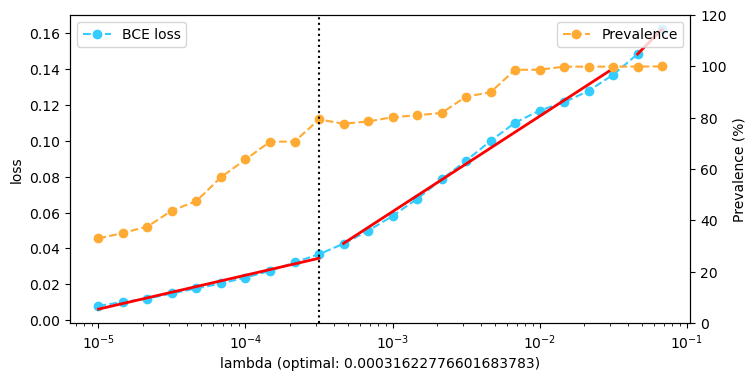

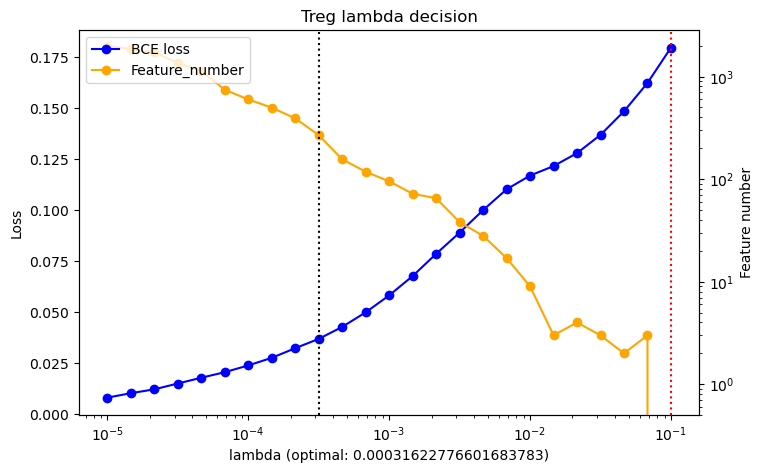

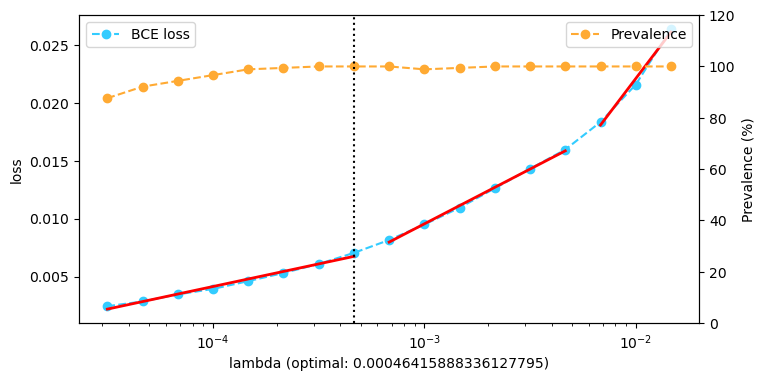

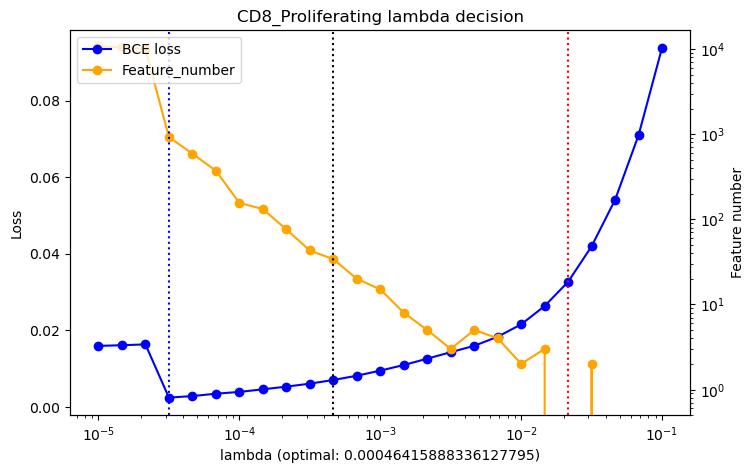

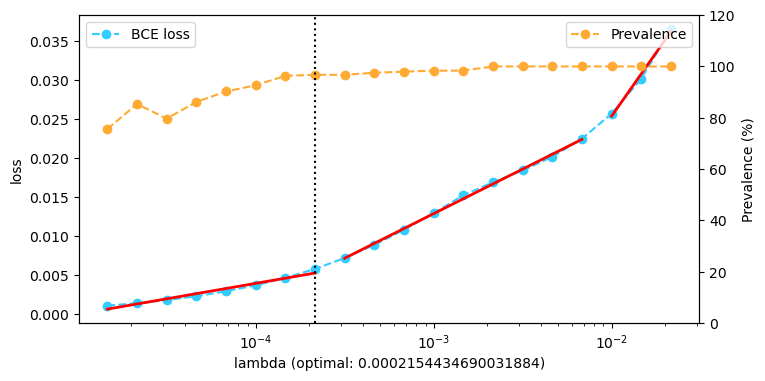

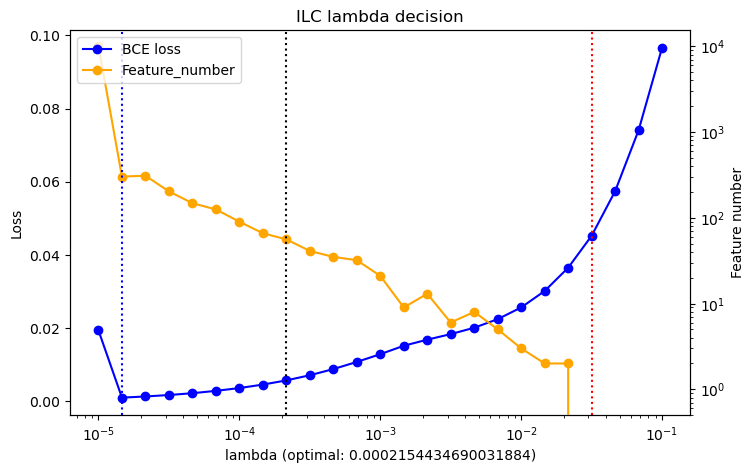

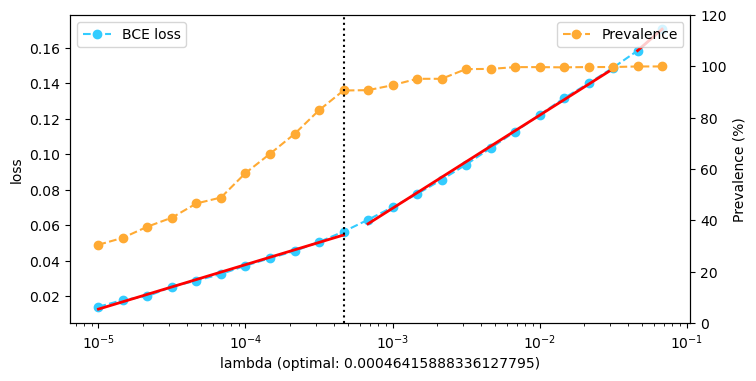

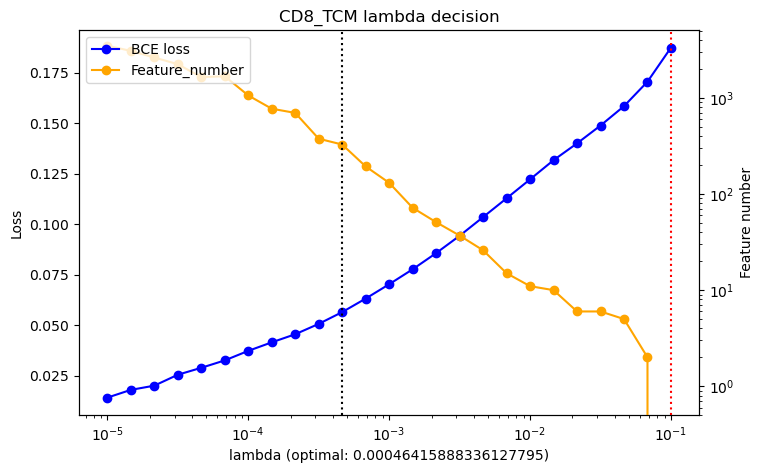

In [10]:
# Start index for each cell type
start_idx_dict = {
    'ASDC': 4,
    'CD4_Proliferating': 2,
    'CD8_Proliferating': 3,
    'Eryth': 3,
    'ILC': 1
}

dir = '/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/lambda_decision_v3/'
for celltype in queue:
    start_idx = start_idx_dict.get(celltype, 0)
    print('====================')
    print(celltype, start_idx)
    run_lmbd_decision(celltype, start_idx=start_idx, output_dir=dir)

In [11]:
opt_lmbd_dict

{'dnT': 0.00046415888336127795,
 'Treg': 0.00031622776601683783,
 'CD8_Proliferating': 0.00046415888336127795,
 'ILC': 0.0002154434690031884,
 'CD8_TCM': 0.00046415888336127795}

In [12]:
feature_no_dict

{'dnT': 63, 'Treg': 268, 'CD8_Proliferating': 34, 'ILC': 56, 'CD8_TCM': 328}

In [13]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/opt_lambda_json')
with open('L2_Harmony_opt_lmbd_v3.json', 'w') as f:
    json.dump(opt_lmbd_dict, f)